#### This notebook will discuss nitty-gritty and in-depth concept and implementation of Supervised Linear Regression and Classification problem of Machine Learning. I'm using 'housing.csv' and 'MNIST digit.csv' datasets. Also, I'm refering book 'Hands-On Machine Learning with Scikit-Learn & TensorFlow' by Aurélien Géron.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df=pd.read_csv('https://raw.githubusercontent.com/ageron/handson-ml/master/datasets/housing/housing.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [4]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [5]:
df.isnull().sum()[df.isnull().sum()!=0]

total_bedrooms    207
dtype: int64

In [6]:
df['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [7]:
df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


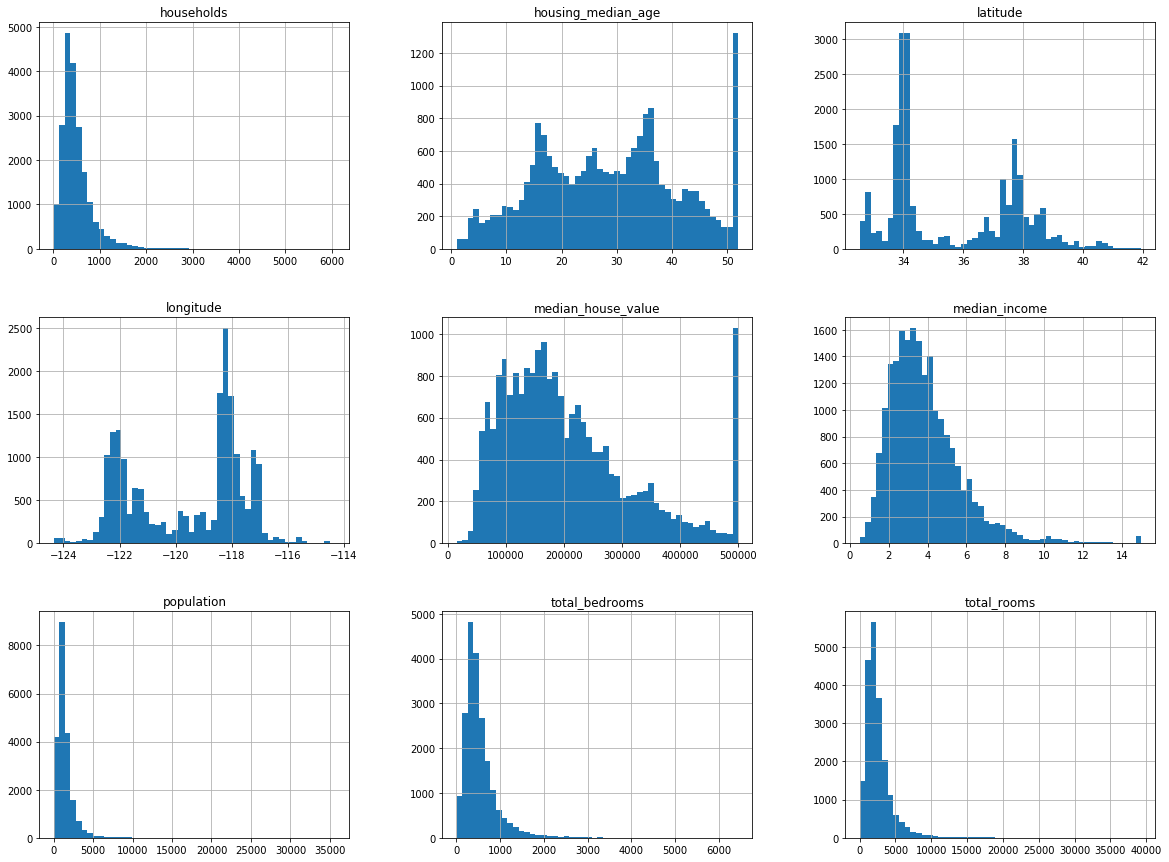

In [8]:
%matplotlib inline
df.hist(bins=50,figsize=(20,15))
plt.show()

First, the median income attribute does not look like it is expressed in US dollars
(USD). After checking with the team that collected the data, you are told that the
data has been scaled and capped at 15 (actually 15.0001) for higher median
incomes, and at 0.5 (actually 0.4999) for lower median incomes.


The housing median age and the median house value were also capped. The latter
may be a serious problem since it is your target attribute (your labels). Your
Machine Learning algorithms may learn that prices never go beyond that limit.

### Create a Test Set

In [9]:
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [10]:
train_set, test_set = split_train_test(df, 0.2)
print(len(train_set), "train +", len(test_set), "test")

16512 train + 4128 test


Well, this works, but it is not perfect: if you run the program again, it will generate a
different test set! Over time, you (or your Machine Learning algorithms) will get to
see the whole dataset, which is what you want to avoid.

One solution is to save the test set on the first run and then load it in subsequent
runs. Another option is to set the random number generator’s seed before calling np.random.permutation(), so that it always generates the same shuffled indices.

Now, Let’s look at the median income histogram more closely

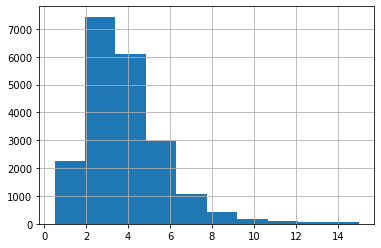

In [11]:
df.median_income.hist()
plt.show()

Most median income values are clustered around 2–5 (tens of thousands of dollars),but some median incomes go far beyond 6. It is important to have a sufficient number of instances in your dataset for each stratum, or else the estimate of the stratum’s importance may be biased.This means that you should not have too many strata, and each stratum should be large enough. The following code creates
an income category attribute by dividing the median income by 1.5 (to limit the number of income categories), and rounding up using ceil (to have discrete categories), and then merging all the categories greater than 5 into category 5:

In [12]:
pd.DataFrame(df['median_income'].describe()).T

,count,mean,std,min,25%,50%,75%,max
median_income,20640.0,3.870671,1.899822,0.4999,2.5634,3.5348,4.74325,15.0001


In [13]:
df['income_cat']=np.ceil(df['median_income']/1.5)
df['income_cat'].value_counts()

3.0     7236
2.0     6581
4.0     3639
5.0     1423
1.0      822
6.0      532
7.0      189
8.0      105
9.0       50
11.0      49
10.0      14
Name: income_cat, dtype: int64

In [14]:
df['income_cat'].where(df['income_cat']<5.0,5,inplace=True)

In [15]:
df['income_cat'].value_counts(normalize=True)

3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.114438
1.0    0.039826
Name: income_cat, dtype: float64

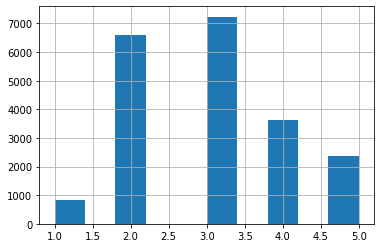

In [16]:
df['income_cat'].hist()
plt.show()

In [17]:
from sklearn.model_selection import StratifiedShuffleSplit

split=StratifiedShuffleSplit(n_splits=1,test_size=0.2,random_state=42)
for train_index,test_index in split.split(df,df.income_cat):
    strat_train_set = df.loc[train_index]
    strat_test_set = df.loc[test_index]

In [18]:
from sklearn.model_selection import train_test_split
def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(df, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall": income_cat_proportions(df),
    "Stratified": income_cat_proportions(strat_test_set),
    "Random": income_cat_proportions(test_set),
}).sort_index()
compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100

In [19]:
compare_props

,Overall,Stratified,Random,Rand. %error,Strat. %error
1.0,0.039826,0.039729,0.040213,0.973236,-0.243309
2.0,0.318847,0.318798,0.324370,1.732260,-0.015195
3.0,0.350581,0.350533,0.358527,2.266446,-0.013820
4.0,0.176308,0.176357,0.167393,-5.056334,0.027480
5.0,0.114438,0.114583,0.109496,-4.318374,0.127011


Now you should remove the income_cat attribute so the data is back to its original state:

In [20]:
for set in (strat_train_set, strat_test_set):
    set.drop(["income_cat"], axis=1, inplace=True)

In [21]:
strat_train_set.shape

(16512, 10)

### Discover and Visualize the Data to Gain Insights

In [22]:
housing = strat_train_set.copy()

**Visualizing Geographical Data**

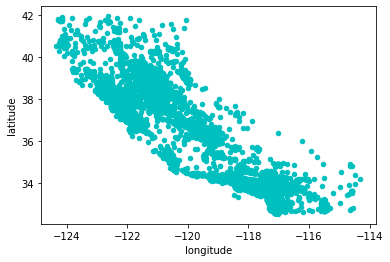

In [23]:
housing.plot(kind='scatter',x='longitude',y='latitude',color='c')
plt.show()

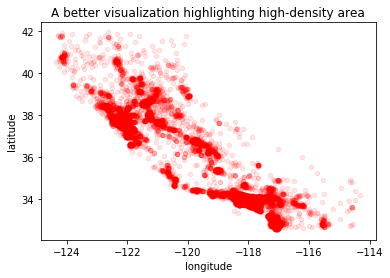

In [24]:
housing.plot(kind='scatter',x='longitude',y='latitude',color='r',alpha=0.1)
plt.title('A better visualization highlighting high-density area')
plt.show()

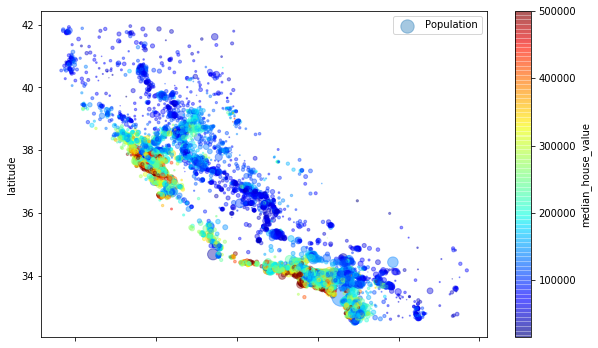

In [25]:
housing.plot(kind='scatter',x='longitude',y='latitude',alpha=0.4,s=housing['population']/100
            ,label='Population',c='median_house_value',cmap=plt.get_cmap('jet'),colorbar=True
             ,figsize=(10,6))
plt.legend()
plt.show()

In [26]:
corr_matrix=housing.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

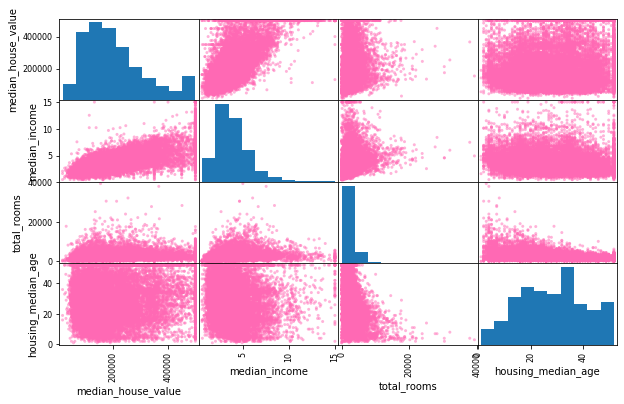

In [27]:
from pandas.plotting import scatter_matrix
scatter_matrix(housing[["median_house_value", "median_income", "total_rooms","housing_median_age"]]
               ,figsize=(10,6),color='hotpink')
plt.show()

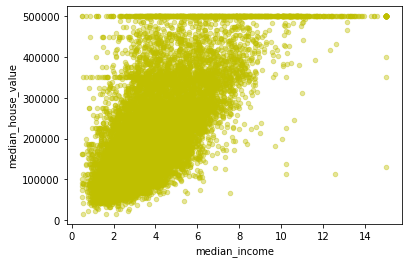

In [28]:
housing.plot(kind='scatter',x='median_income',y='median_house_value',alpha=0.4,color='y')
plt.show()

This plot reveals a few things. First, the correlation is indeed very strong; you can
clearly see the upward trend and the points are not too dispersed. Second, the price
cap that we noticed earlier is clearly visible as a horizontal line at 500,000. But this
plot reveals other less obvious straight lines: a horizontal line around 450,000,
another around 350,000, perhaps one around 280,000, and a few more below that.
You may want to try removing the corresponding districts to prevent your algorithms
from learning to reproduce these data quirks.

### Experimenting with Atrribute Combinations (Feature Engineering)

In [29]:
housing.head(1)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,286600.0,<1H OCEAN


In [30]:
housing['rooms_per_household']=housing['total_rooms']/housing.households
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

In [31]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

In [32]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

#### Data Cleaning

We will use imputer class to raplace the null values, but first we have to remove the object column 
since imputer class does work only on numerical columns

In [33]:
housing_num=housing.drop('ocean_proximity',axis=1)

In [34]:
from sklearn.impute import SimpleImputer
imputer=SimpleImputer(strategy='median')
imputer.fit(housing_num)

SimpleImputer(add_indicator=False, copy=True, fill_value=None,
              missing_values=nan, strategy='median', verbose=0)

In [35]:
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [36]:
housing_num.median().values

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [37]:
X=imputer.transform(housing_num)

In [38]:
housing_tr=pd.DataFrame(X,columns=housing_num.columns)

In [39]:
housing.ocean_proximity.unique()

array(['<1H OCEAN', 'NEAR OCEAN', 'INLAND', 'NEAR BAY', 'ISLAND'],
      dtype=object)

In [40]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
housing_cat=housing.ocean_proximity
housing_cat_encoded=le.fit_transform(housing_cat)
housing_cat_encoded

array([0, 0, 4, ..., 1, 0, 3])

In [41]:
le.classes_

array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
      dtype=object)

In [42]:
housing_cat_encoded.reshape(-1,1)

array([[0],
       [0],
       [4],
       ...,
       [1],
       [0],
       [3]])

In [43]:
from sklearn.preprocessing import OneHotEncoder
ohe=OneHotEncoder()
housing_cat_1hot=ohe.fit_transform(housing_cat_encoded.reshape(-1,1))

In [44]:
housing_cat_1hot.toarray()

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

We can apply both transformations (from text categories to integer categories, then from integer categories to one-hot vectors) in one shot using the LabelBinarizer class:

In [45]:
from sklearn.preprocessing import LabelBinarizer
lb=LabelBinarizer()
housing_cat_1hot=lb.fit_transform(housing_cat)
housing_cat_1hot

array([[1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       ...,
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0]])

#### Custom Transformers

Although Scikit-Learn provides many useful transformers, you will need to write
your own for tasks such as custom cleanup operations or combining specific
attributes. You will want your transformer to work seamlessly with Scikit-Learn functionalities
(such as pipelines), and since Scikit-Learn relies on duck typing (not inheritance),
all you need is to create a class and implement three methods: fit()
(returning self), transform(), and fit_transform(). You can get the last one for
free by simply adding TransformerMixin as a base class. Also, if you add BaseEstimator as a base class (and avoid *args and *kargs in your constructor) you will get
two extra methods (get_params() and set_params()) that will be useful for automatic
hyperparameter tuning. For example, here is a small transformer class that adds
the combined attributes we discussed earlier:

In [46]:
from sklearn.base import BaseEstimator,TransformerMixin
rooms_ix,bedrooms_ix,population_ix,households_ix=3,4,5,6
class CombinedAttributesAdder(BaseEstimator,TransformerMixin):
    def __init__(self,add_bedrooms_per_room=True):
        self.add_bedrooms_per_room=add_bedrooms_per_room
    def fit(self,X,y=None):
        return self
    def transform(self,X,y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

In this example the transformer has one hyperparameter, add_bedrooms_per_room, set to True by default (it is often helpful to provide sensible defaults). This hyperparameter will allow you to easily find out whether adding this attribute helps the Machine Learning algorithms or not. More generally, you can add a hyperparameter to gate any data preparation step that you are not 100% sure about. The more you automate these data preparation steps, the more combinations you can automatically try out, making it much more likely that you will find a great combination (and saving you a lot of time).

#### Transformation Pipelines

As you can see, there are many data transformation steps that need to be executed in
the right order. Fortunately, Scikit-Learn provides the Pipeline class to help with
such sequences of transformations. Here is a small pipeline for the numerical
attributes:

In [47]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
num_pipeline=Pipeline([('imputer',SimpleImputer(strategy='median')),
                       ('attribs_adder',CombinedAttributesAdder()),
                      ('std_scaler',StandardScaler())])
housing_num_tr=num_pipeline.fit_transform(housing_num)

In [48]:
from sklearn.pipeline import FeatureUnion

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names=attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

num_attribs=list(housing_num.columns)
cat_attribs=['ocean_proximity']

num_pipeline=Pipeline([('selector',DataFrameSelector(num_attribs)),
                       ('imputer',SimpleImputer(strategy='median')),
                       ('attribes_adder',CombinedAttributesAdder()),
                       ('std_scaler',StandardScaler())])

cat_pipeline=Pipeline([('selector',DataFrameSelector(cat_attribs)),
                       ('cat_encoder',OneHotEncoder())])

full_pipeline1=FeatureUnion(transformer_list=[('num_pipeline',num_pipeline),
                                            ('cat_pipeline',cat_pipeline)])

In [49]:
housing_prepared1 = full_pipeline1.fit_transform(housing)

In [50]:
housing_prepared1.shape

(16512, 16)

##### OR, we can do with ColumnTransformer instead of FeatureUnion with less code

In [51]:
from sklearn.compose import ColumnTransformer

num_attribs=list(housing_num.columns)
cat_attribs=['ocean_proximity']
num_pipeline=Pipeline([('imputer',SimpleImputer(strategy='median')),
                       ('attribes_adder',CombinedAttributesAdder()),
                       ('std_scaler',StandardScaler())])

cat_pipeline=Pipeline([('cat_encoder',OneHotEncoder())])

full_pipeline2 = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", cat_pipeline, cat_attribs),
    ])

In [52]:
housing_prepared2 = full_pipeline2.fit_transform(housing)

In [53]:
housing_prepared2.shape

(16512, 16)

In [54]:
np.allclose(housing_prepared1.toarray(),housing_prepared2)

True

### Select and Train a Model

**Training and Evaluating on the Training Set**

In [55]:
from sklearn.linear_model import LinearRegression
lin_reg=LinearRegression()
lin_reg.fit(housing_prepared2,housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [56]:
housing.head(1)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,<1H OCEAN


In [57]:
some_data=housing.iloc[:5]
some_labels=housing_labels.iloc[:5]
some_data_prepared=full_pipeline2.transform(some_data)
print('Predictions:\t',np.round(lin_reg.predict(some_data_prepared),2))
print('Labels:\t\t',list(some_labels))

Predictions:	 [210644.6  317768.81 210956.43  59218.99 189747.56]
Labels:		 [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


In [58]:
from sklearn.metrics import mean_squared_error
housing_predictions=lin_reg.predict(housing_prepared2)
lin_mse=mean_squared_error(housing_predictions,housing_labels)
lin_rmse=np.sqrt(lin_mse)
lin_rmse

68628.19819848923

Okay, this is better than nothing but clearly not a great score: most districts median_housing_values range between 120,000-265,000 dollars, so a typical prediction error of $68,628 is not very satisfying. This is an example of a model underfitting the training data. When this happens it can mean that the features do not provide enough information to make good predictions, or that the model is not powerful enough.

The main ways to fix underfitting are to:
    1. Select a more powerful model or,
    2. To feed the training algorithm with better features.
    3. To reduce the constraints on the model.

In [59]:
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared2, housing_labels)
housing_predictions = tree_reg.predict(housing_prepared2)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

It is much more likely that the model has badly overfit the data. How can you be sure?
As we saw earlier, you don’t want to touch the test set until you are ready to launch a model you are confident about, so you need to use part of the training set for training, and part for model validation.

##### Better Evaluation Using Cross-Validation

One way to evaluate the Decision Tree model would be to use the train_test_split function to split the training set into a smaller training set and a validation set, then train your models against the smaller training set and evaluate them against the validation set.

A great alternative is to use Scikit-Learn’s cross-validation feature. The following code performs K-fold cross-validation: it randomly splits the training set into 10 distinct subsets called folds, then it trains and evaluates the Decision Tree model 10 times, picking a different fold for evaluation every time and training on the other 9 folds. The result is an array containing the 10 evaluation scores:

In [60]:
from sklearn.model_selection import cross_val_score
scores=cross_val_score(tree_reg,housing_prepared2,housing_labels,cv=10,
                       scoring='neg_mean_squared_error')
rmse_score=np.sqrt(-scores)

In [61]:
rmse_score.std()

2707.48912642345

In [62]:
rmse_score.mean()

70995.6012730033

In [63]:
lin_scores=cross_val_score(lin_reg,housing_prepared2,housing_labels,cv=10,
                           scoring='neg_mean_squared_error')

In [64]:
lin_rmsescore=np.sqrt(-lin_scores)

In [65]:
lin_rmsescore.mean()

69052.46136345083

In [66]:
lin_rmsescore.std()

2731.674001798346

That’s right: the Decision Tree model is overfitting so badly that it performs worse than the Linear Regression model.

In [67]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared2, housing_labels)
f_scores=cross_val_score(forest_reg,housing_prepared2,housing_labels,cv=10,
                       scoring='neg_mean_squared_error')
rmse_fscore=np.sqrt(-f_scores)

In [68]:
rmse_fscore.mean()

50196.171111639225

In [69]:
rmse_fscore.std()

1934.7583995457983

### Fine-Tune Your Model

**1. Grid Search**

In [70]:
from sklearn.model_selection import GridSearchCV
param_grid=[{'n_estimators':[3,10,30],'max_features':[2,4,6,8]},
           {'bootstrap':[False],'n_estimators':[3,10],'max_features':[2,3,4]}]
forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
scoring='neg_mean_squared_error')
grid_search.fit(housing_prepared2, housing_labels)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jo

In [71]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

In [72]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=8, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=30, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [73]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

63033.17272135119 {'max_features': 2, 'n_estimators': 3}
55429.852700562304 {'max_features': 2, 'n_estimators': 10}
52905.52326208499 {'max_features': 2, 'n_estimators': 30}
60385.282231170095 {'max_features': 4, 'n_estimators': 3}
53184.30669432324 {'max_features': 4, 'n_estimators': 10}
50469.516675702485 {'max_features': 4, 'n_estimators': 30}
59266.562316712996 {'max_features': 6, 'n_estimators': 3}
52046.908544652135 {'max_features': 6, 'n_estimators': 10}
49999.54382261822 {'max_features': 6, 'n_estimators': 30}
59328.42855855584 {'max_features': 8, 'n_estimators': 3}
52333.69923883764 {'max_features': 8, 'n_estimators': 10}
49941.000661577134 {'max_features': 8, 'n_estimators': 30}
63136.58391636859 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54285.10952660953 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
59923.77860491544 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52636.05287466402 {'bootstrap': False, 'max_features': 3, 'n_estimator

In [74]:
feature_importance=grid_search.best_estimator_.feature_importances_

In [75]:
feature_importance

array([7.29391433e-02, 6.71154058e-02, 4.27777920e-02, 1.53403330e-02,
       1.38165269e-02, 1.42495370e-02, 1.37306220e-02, 3.62397347e-01,
       4.88165162e-02, 1.11407568e-01, 6.14280618e-02, 5.14968924e-03,
       1.65103115e-01, 8.00680408e-05, 2.63075238e-03, 3.01752210e-03])

In [76]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_one_hot_attribs = list(lb.classes_)
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importance, attributes), reverse=True)

[(0.36239734731347906, 'median_income'),
 (0.1651031150499245, 'INLAND'),
 (0.1114075678249582, 'pop_per_hhold'),
 (0.07293914334044065, 'longitude'),
 (0.0671154057564583, 'latitude'),
 (0.06142806180081247, 'bedrooms_per_room'),
 (0.04881651623176049, 'rooms_per_hhold'),
 (0.04277779203579514, 'housing_median_age'),
 (0.015340333018784054, 'total_rooms'),
 (0.014249536955788915, 'population'),
 (0.013816526940989013, 'total_bedrooms'),
 (0.013730621968723543, 'households'),
 (0.005149689243009269, '<1H OCEAN'),
 (0.0030175220957439704, 'NEAR OCEAN'),
 (0.002630752382580988, 'NEAR BAY'),
 (8.006804075139434e-05, 'ISLAND')]

#### Evaluate Your System on the Test Set

In [77]:
final_model = grid_search.best_estimator_
X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()
X_test_prepared = full_pipeline2.transform(X_test)

In [78]:
final_predictions = final_model.predict(X_test_prepared)
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

In [79]:
final_rmse.mean()

47582.26756681482

# Classification

In [80]:
import pandas as pd

In [81]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'DESCR', 'details', 'categories', 'url'])

In [82]:
X=mnist.data
y=mnist.target

In [83]:
X.shape,y.shape

((70000, 784), (70000,))

In [84]:
y.dtype #Its object

dtype('O')

In [85]:
import numpy as np
y = y.astype(np.uint8)

In [86]:
y.dtype

dtype('uint8')

In [87]:
import matplotlib
import matplotlib.pyplot as plt

In [88]:
some_digit=X[36000]
some_digit_image=some_digit.reshape(28,28)

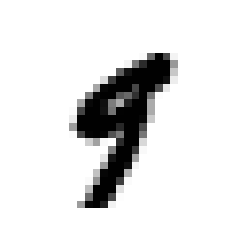

In [89]:
plt.imshow(some_digit_image,cmap=matplotlib.cm.binary,interpolation='nearest')
plt.axis("off")
plt.show()

In [90]:
y[36000]

9

In [91]:
X_train,y_train,X_test,y_test=X[:60000],y[:60000],X[60000:],y[60000:]

In [92]:
X_train.shape,y_train.shape,X_test.shape,y_test.shape

((60000, 784), (60000,), (10000, 784), (10000,))

Let’s also shuffle the training set; this will guarantee that all cross-validation folds will be similar (you don’t want one fold to be missing some digits)

In [93]:
import numpy as np

In [94]:
shuffle_index=np.random.permutation(60000)
X_train,y_train=X_train[shuffle_index],y_train[shuffle_index]

### Training a Binary Classifier

Let's predict digit 5 first:

In [95]:
y_train_9=(y_train==9)
y_test_9=(y_test==9)

In [96]:
np.unique(y_train_9)

array([False,  True])

Let's first use SGD(Stochastic Gradient Decent).This classifier has the advantage of being capable of handling very large datasets efficietly. This is in part because SGD deals with training instances independently, one at a time (which also makes SGD well suited for online learning).

In [97]:
from sklearn.linear_model import SGDClassifier
sgd_clf=SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(X_train,y_train_9)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [98]:
sgd_clf.predict([some_digit])

array([False])

The classifier guesses that this image represents a 9 (True). Looks like it guessed right in this particular case! Now, let’s evaluate this model’s performance.

#### Performance Measures

In [99]:
from sklearn.model_selection import cross_val_score
cvscore=cross_val_score(sgd_clf,X_train,y_train_9,cv=10,scoring='accuracy')

In [100]:
cvscore

array([0.932     , 0.952     , 0.9515    , 0.91183333, 0.94166667,
       0.94533333, 0.942     , 0.9555    , 0.942     , 0.93666667])

In [101]:
cvscore.mean()

0.94105

### OR

In [102]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfold=StratifiedKFold(n_splits=3)

for train_index,test_index in skfold.split(X_train,y_train_9):
    clone_clf=clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = (y_train_9[train_index])
    X_test_fold = X_train[test_index]
    y_test_fold = (y_train_9[test_index])
    
    clone_clf.fit(X_train_folds,y_train_folds)
    y_pred=clone_clf.predict(X_test_fold)
    n_correct=sum(y_pred==y_test_fold)
    print(n_correct/len(y_pred))

0.94945
0.9485
0.932


As we know that accuracy is generally not the preferred performance measure for classifiers, especially when you are dealing with skewed datasets (i.e., when some classes are much more frequent than others).

#### Confusion Matrix

To compute the confusion matrix, you first need to have a set of predictions, so they
can be compared to the actual targets. You could make predictions on the test set, but
let’s keep it untouched for now (remember that you want to use the test set only at the
very end of your project, once you have a classifier that you are ready to launch).
Instead, you can use the cross_val_predict() function:

In [103]:
from sklearn.model_selection import cross_val_predict
y_train_pred=cross_val_predict(sgd_clf,X_train,y_train_9,cv=3)

Just like the cross_val_score() function, cross_val_predict() performs K-fold cross-validation, but instead of returning the evaluation scores, it returns the predictions made on each test fold.

In [104]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_9,y_train_pred)

array([[53250,   801],
       [ 2600,  3349]], dtype=int64)

In [105]:
tn,fp,fn,tp=confusion_matrix(y_train_9,y_train_pred).ravel()

In [106]:
tn,fp,fn,tp

(53250, 801, 2600, 3349)

#### Precision and Recall

In [107]:
from sklearn.metrics import precision_score,recall_score,f1_score

In [108]:
precision_score(y_train_9,y_train_pred)

0.8069879518072289

In [109]:
recall_score(y_train_9,y_train_pred)

0.5629517565977475

In [110]:
f1_score(y_train_9,y_train_pred)

0.663233983562729

In [111]:
y_scores=cross_val_predict(sgd_clf,X_train,y_train_9,cv=3,method='decision_function')

In [112]:
y_scores

array([ -2317.22862577, -16950.3857018 ,  -6951.06418677, ...,
       -21919.06572378,  -2486.75722561, -86273.87562704])

In [113]:
from sklearn.metrics import precision_recall_curve

In [114]:
precisions,recalls,thresholds=precision_recall_curve(y_train_9,y_scores)
precisions,recalls,thresholds

(array([0.10615821, 0.10614226, 0.10614415, ..., 1.        , 1.        ,
        1.        ]),
 array([1.00000000e+00, 9.99831905e-01, 9.99831905e-01, ...,
        3.36190956e-04, 1.68095478e-04, 0.00000000e+00]),
 array([-44066.38711946, -44064.67177682, -44062.49431143, ...,
         17202.07249282,  18584.23558816,  21018.0657672 ]))

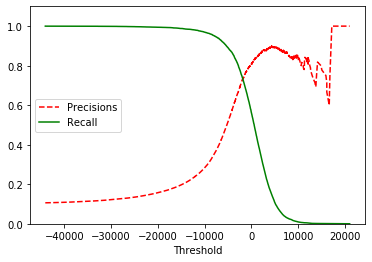

In [115]:
def plot_precision_recall_vs_threshold(precisions,recalls,thresholds):
    plt.plot(thresholds,precisions[:-1],"r--",label="Precisions")
    plt.plot(thresholds,recalls[:-1],"g-",label='Recall')
    plt.xlabel("Threshold")
    plt.legend(loc="center left")
    plt.ylim([0, 1.1])
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

Another way to select a good precision/recall tradeoff is to plot precision directly against recall.

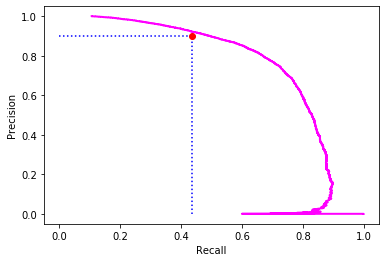

In [116]:
plt.plot(precisions,recalls,'magenta',linewidth=2)
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.plot([0.4368, 0.4368], [0., 0.9], "b:")
plt.plot([0.0, 0.4368], [0.9, 0.9], "b:")
plt.plot([0.4368], [0.9], "ro")
plt.show()

In [117]:
y_train_pred_90 = (y_scores > 10000)

In [118]:
precision_score(y_train_9, y_train_pred_90)

0.835820895522388

In [119]:
recall_score(y_train_9, y_train_pred_90)

0.009413346780971592

A high-precision classifier is not very useful if its recall is too low!

### The ROC Curve

The receiver operating characteristic (ROC) curve is another common tool used with binary classifiers. It is very similar to the precision/recall curve, but instead of plotting precision versus recall, the ROC curve plots the true positive rate (another name for recall) against the false positive rate. The FPR is the ratio of negative instances that are incorrectly classified as positive. It is equal to one minus the true negative rate, which is the ratio of negative instances that are correctly classified as negative. The TNR is also called specificity. Hence the ROC curve plots sensitivity (recall) versus
1 – specificity.
To plot the ROC curve, you first need to compute the TPR and FPR for various threshold
values, using the roc_curve() function:

In [120]:
from sklearn.metrics import roc_curve

In [121]:
fpr, tpr, thresholds=roc_curve(y_train_9,y_scores)

In [122]:
thresholds

array([  21019.0657672 ,   21018.0657672 ,   17202.07249282, ...,
        -44064.67177682,  -44066.38711946, -118982.03498524])

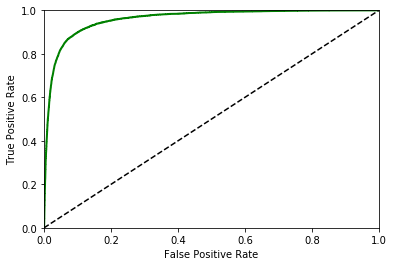

In [123]:
def plot_roc_curve(fpr,tpr,label=None):
    plt.plot(fpr,tpr,linewidth=2,label=label,color='g')
    plt.plot(fpr,fpr, 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
plot_roc_curve(fpr, tpr)
plt.show()

Once again there is a tradeoff: the higher the recall (TPR), the more false positives (FPR) the classifier produces. The dotted line represents the ROC curve of a purely random classifier; a good classifier stays as far away from that line as possible (toward the top-left corner). One way to compare classifiers is to measure the area under the curve (AUC). A perfect classifier will have a ROC AUC equal to 1, whereas a purely random classifier will have a ROC AUC equal to 0.5

In [124]:
from sklearn.metrics import roc_auc_score

In [125]:
roc_auc_score(y_train_9,y_scores)

0.9597375798547209

In [126]:
from sklearn.ensemble import RandomForestClassifier
forest_clf=RandomForestClassifier(random_state=42)
y_probas_forest=cross_val_predict(forest_clf,X_train,y_train_9,cv=3,method="predict_proba")

In [127]:
y_probas_forest

array([[0.63, 0.37],
       [1.  , 0.  ],
       [0.99, 0.01],
       ...,
       [0.98, 0.02],
       [0.05, 0.95],
       [1.  , 0.  ]])

In [128]:
y_scores_forest=y_probas_forest[:,1]

In [129]:
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_9,y_scores_forest)

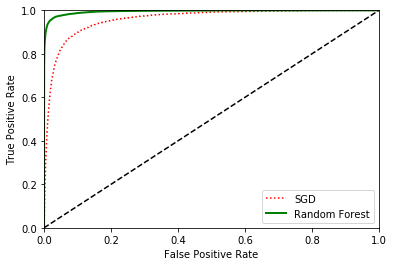

In [130]:
plt.plot(fpr,tpr,"r:",label="SGD")
plot_roc_curve(fpr_forest, tpr_forest,"Random Forest")
plt.legend(loc="lower right")
plt.show()

In [131]:
roc_auc_score(y_train_9,y_scores_forest)

0.9950887033068284

In [132]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_9, cv=3)
precision_score(y_train_9, y_train_pred_forest)

0.9829143754909663

In [133]:
recall_score(y_train_9,y_train_pred_forest)

0.841317868549336

## Multiclass Classification

Some algorithms (such as Random Forest classifiers or naive Bayes classifiers) are capable of handling multiple classes directly. Others (such as Support Vector Machine classifiers or Linear classifiers) are strictly binary classifiers. However, there are various strategies that you can use to perform multiclass classification using multiple binary classifiers.

Some algorithms (such as Support Vector Machine classifiers) scale poorly with the size of the training set, so for these algorithms OvO is preferred since it is faster to train many classifiers on small training sets than training few classifiers on large training sets. For most binary classification algorithms, however, OvA is preferred.

In [134]:
sgd_clf.fit(X_train,y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [135]:
some_digit=X[3500]
some_digit_image=some_digit.reshape(28,28)

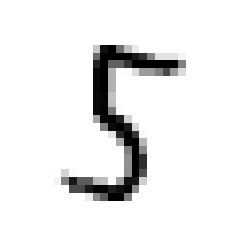

In [136]:
plt.imshow(some_digit_image,cmap=matplotlib.cm.binary,interpolation='nearest')
plt.axis("off")
plt.show()

In [137]:
sgd_clf.predict([some_digit])

array([5], dtype=uint8)

This code trains the SGDClassifier on the training set using the original target classes from 0 to 9 (y_train), instead of the 5-versus-all target classes (y_train_5). Then it makes a prediction (a correct one in this case). Under the hood, Scikit-Learn actually trained 10 binary classifiers, got their decision scores for the image, and selected the class with the highest score.

In [138]:
some_digit_scores=sgd_clf.decision_function([some_digit])
some_digit_scores

array([[-28389.34658744, -23401.8067855 ,  -5303.87373631,
         -2709.02071379, -14019.28940041,   4975.0829649 ,
        -31485.21959098, -11635.7993693 ,   1505.03822748,
         -4294.03155105]])

In [139]:
np.argmax(some_digit_scores)

5

In [140]:
sgd_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [141]:
sgd_clf.classes_[5]

5

In [142]:
from sklearn.multiclass import OneVsOneClassifier
ovo_clf=OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train,y_train)
ovo_clf.predict([some_digit])

array([5], dtype=uint8)

In [143]:
len(ovo_clf.estimators_)

45

In [144]:
forest_clf.fit(X_train,y_train)
forest_clf.predict([some_digit])

array([5], dtype=uint8)

This time Scikit-Learn did not have to run OvA or OvO because Random Forest classifiers can directly classify instances into multiple classes. You can call predict_proba() to get the list of probabilities that the classifier assigned to each instance for each class:

In [145]:
forest_clf.predict_proba([some_digit])

array([[0.01, 0.01, 0.  , 0.03, 0.  , 0.95, 0.  , 0.  , 0.  , 0.  ]])

You can see that the classifier is fairly confident about its prediction: the 0.91 at the 5th index in the array means that the model estimates an 91% probability that the image represents as 5 and 6% probability that 5 can be missclassified as 3.

In [146]:
accuracy_score=cross_val_score(sgd_clf,X_train,y_train,cv=3,scoring="accuracy")

In [147]:
accuracy_score

array([0.8545, 0.8826, 0.8761])

In [148]:
accuracy_score.mean()

0.8710666666666667

It gets over 87% on all test folds. If you used a random classifier, you would get 10% accuracy, so this is not such a bad score, but you can still do much better. For example,
simply scaling the inputs, increases accuracy above 90%.

In [149]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
X_train_scaler=scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf,X_train_scaler,y_train,cv=3,scoring="accuracy")

array([0.905  , 0.89605, 0.89635])

### Error Analysis

In [150]:
y_train_pred=cross_val_predict(sgd_clf,X_train_scaler,y_train,cv=3)
conf_mtx=confusion_matrix(y_train,y_train_pred)
conf_mtx

array([[5592,    0,   16,    4,    8,   39,   33,    4,  226,    1],
       [   0, 6413,   39,   23,    3,   43,    4,    7,  201,    9],
       [  24,   27, 5254,   90,   65,   18,   65,   38,  367,   10],
       [  22,   21,  118, 5224,    1,  204,   25,   42,  409,   65],
       [  11,   14,   44,   10, 5213,    7,   33,   24,  350,  136],
       [  28,   17,   30,  140,   48, 4480,   76,   21,  519,   62],
       [  32,   18,   43,    3,   43,   88, 5547,    6,  138,    0],
       [  18,   14,   50,   23,   44,   14,    3, 5702,  187,  210],
       [  18,   61,   44,   92,    1,  125,   31,    8, 5430,   41],
       [  24,   23,   26,   56,  126,   34,    1,  183,  383, 5093]],
      dtype=int64)

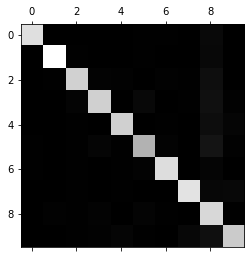

In [151]:
plt.matshow(conf_mtx,cmap=plt.cm.gray)
plt.show()

Analyzing individual errors can also be a good way to gain insights on what your classifier is doing and why it is failing, but it is more difficult and time-consuming.For example, let’s plot examples of 3s and 5s:

In [152]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

In [153]:
def plot_digits(instances, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    import matplotlib as mpl
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

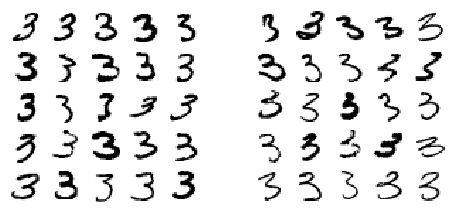

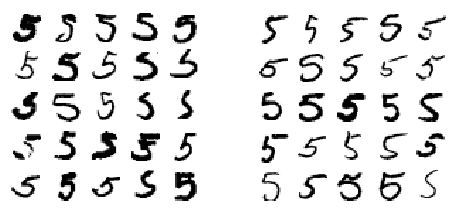

In [154]:
plt.figure(figsize=(8,8))
plt.subplot(221); 
plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); 
plot_digits(X_ab[:25], images_per_row=5)
plt.figure(figsize=(8,8))
plt.subplot(223); 
plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); 
plot_digits(X_bb[:25], images_per_row=5)
plt.show()

## Multilabel Classification

Until now each instance has always been assigned to just one class. In some cases you may want your classifier to output multiple classes for each instance. For example, consider a face-recognition classifier: what should it do if it recognizes several people on the same picture? Of course it should attach one label per person it recognizes. Say the classifier has been trained to recognize three faces, Alice, Bob, and Charlie; then when it is shown a picture of Alice and Charlie, it should output [1, 0, 1] (meaning “Alice yes, Bob no, Charlie yes”). Such a classification system that outputs multiple binary labels is called a multilabel classification system.

In [155]:
from sklearn.neighbors import KNeighborsClassifier

In [156]:
y_train_large=(y_train>=7)
y_train_odd=(y_train%2==1)
y_multilabel=np.c_[y_train_large,y_train_odd]

In [157]:
knn_clf=KNeighborsClassifier()
knn_clf.fit(X_train,y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

This code creates a y_multilabel array containing two target labels for each digit image: the first indicates whether or not the digit is large (7, 8, or 9) and the second indicates whether or not it is odd. The next lines create a KNeighborsClassifier instance (which supports multilabel classification, but not all classifiers do) and we train it using the multiple targets array. Now you can make a prediction, and notice that it outputs two labels:

In [158]:
knn_clf.predict([some_digit])

array([[False,  True]])

And it gets it right! The digit 5 is indeed not large (False) and odd (True).

**Warning!!** The below code might take hours to execute.

In [ ]:
y_train_knn_pred=cross_val_predict(knn_clf,X_train,y_multilabel,cv=3)
f1_score(y_train,y_train_knn_pred,average="macro")
#Output: 0.976410265560605

This assumes that all labels are equally important, which may not be the case. In particular, if you have many more pictures of Alice than of Bob or Charlie, you may want to give more weight to the classifier’s score on pictures of Alice. One simple option is to give each label a weight equal to its support (i.e., the number of instances with that target label). To do this, simply set average="weighted" in the preceding code

## Multioutput Classification

The last type of classification task we are going to discuss here is called multioutputmulticlass
classification (or simply multioutput classification). It is simply a generalization of multilabel classification where each label can be multiclass (i.e., it can have more than two possible values).

To illustrate this, let’s build a system that removes noise from images. It will take as
input a noisy digit image, and it will (hopefully) output a clean digit image, represented
as an array of pixel intensities, just like the MNIST images. Notice that the
classifier’s output is multilabel (one label per pixel) and each label can have multiple
values (pixel intensity ranges from 0 to 255). It is thus an example of a multioutput
classification system.

Let’s start by creating the training and test sets by taking the MNIST images and
adding noise to their pixel intensities using NumPy’s randint() function. The target
images will be the original images:

In [160]:
noise_train = np.random.randint(0, 100, (len(X_train), 784))
noise_test = np.random.randint(0, 100, (len(X_test), 784))

In [161]:
X_train_mod = X_train + noise_train
X_test_mod = X_test + noise_test
y_train_mod = X_train
y_test_mod = X_test

In [164]:
import matplotlib as mpl
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

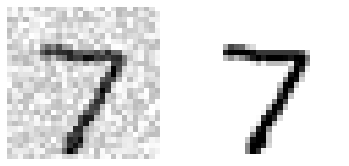

In [165]:
some_index = 0
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
plt.show()

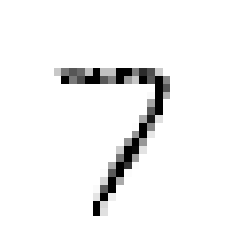

In [166]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)